In [1]:
# default_exp feature_comparison

# Feature comparison between IDEAS, CP and SCIP features

In this notebook, we will compare feature sets generated using IDEAS, CellProfiler and SCIP. 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from joblib import load, dump
from pathlib import Path
import uuid
import re
import scipy

import pyarrow.parquet as pq

from ehv import load as e_load, core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [4]:
# export
import seaborn
import fcsparser
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, spearmanr
from ehv import core

In [5]:
from ehv.masking import plot_scip_segmentation

## Loading the three feature sets

In [ ]:
# cellprofiler features
df_cp = pandas.concat([
    pandas.read_csv(f"/vsc-mounts/gent-user/420/vsc42015/vsc_data_vo/datasets/weizmann/EhV/v2/results/cp_output/202111022047_4/{i}/BF_cells_on_grid.csv", skiprows=1)
    for i in range(1,5)
])
df_cp = df_cp.drop(columns=df_cp.filter(regex="\.1$"))

cp_meta_cols = ["ImageNumber", "ObjectNumber", "Number_Object_Number"]
cp_meta_cols.extend(df_cp.filter(regex="(FileName|PathName)").columns.values.tolist())
df_cp = df_cp.rename(columns=lambda col: f"meta_{col.lower()}" if col in cp_meta_cols else f"feat_{col.lower()}")
df_cp = df_cp[~df_cp["meta_pathname_1"].isna()]

groups = df_cp["meta_pathname_1"].map(lambda p: re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", Path(p).name).groupdict()).tolist()
df_cp["meta_group"] = list(map(lambda a: int(a["group"]), groups))
df_cp["meta_type"] = list(map(lambda a: a["type"], groups))
df_cp["meta_replicate"] = list(map(lambda a: int(a["replicate"]), groups))

df_cp = df_cp.drop(columns=df_cp.filter(regex="(filemame|pathname)").columns)

df_cp.shape

In [ ]:
df_cp = df_cp[~df_cp["feat_areashape_area"].isna()]
df_cp.shape

In [6]:
df_scip = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/features.parquet").to_pandas()
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip.shape

(142451, 1296)

In [7]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(131783, 1296)

In [8]:
# ideas features
tmp = []
for p in Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

# Comparing features between IDEAS and SCIP

In [9]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group"])

In [10]:
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group"])

In [11]:
df_joined = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.drop(columns="meta_type").rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)

In [12]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df_joined = df_joined.rename(columns=rename)

In [13]:
# export
def compare_features(df, x1, x2):
    fig, ax = plt.subplots(dpi=150)
    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    sorted_index = df[x1].sort_values().index
    z1 = df[x1].values
    z2 = df[x2].values

    sorted_index = numpy.argsort(z1)
    z = numpy.polyfit(z1, z2, 1)
    y_hat = numpy.poly1d(z)(z1[sorted_index])
    ax.plot(z1[sorted_index], y_hat, "--", lw=0.5, color="grey")
    ax.scatter(z1[sorted_index], z2[sorted_index], s=0.5, alpha=0.5, edgecolors="none")
    # ax.set_title(r'pearson = %.4f, spearman = %.4f' % (pearsonr(z1,z2)[0], spearmanr(z1,z2)[0]))
    
    return ax

### Texture

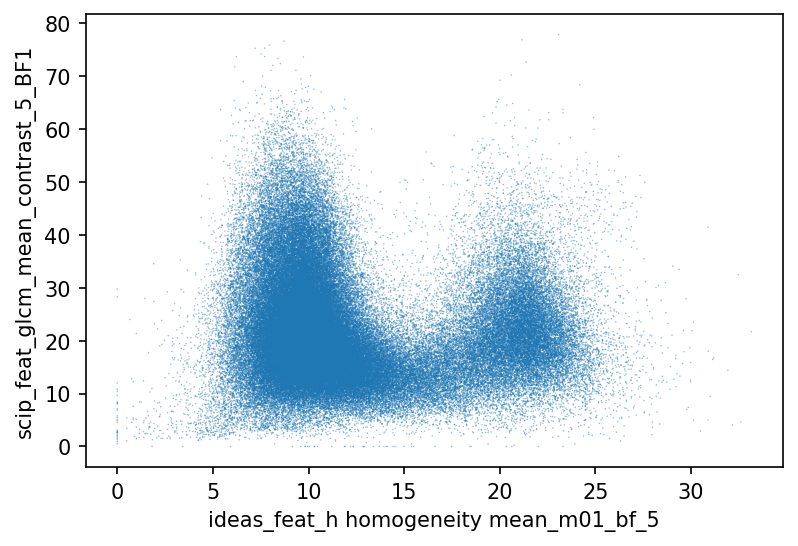

In [14]:
compare_features(df_joined, "ideas_feat_h homogeneity mean_m01_bf_5", "scip_feat_glcm_mean_contrast_5_BF1")

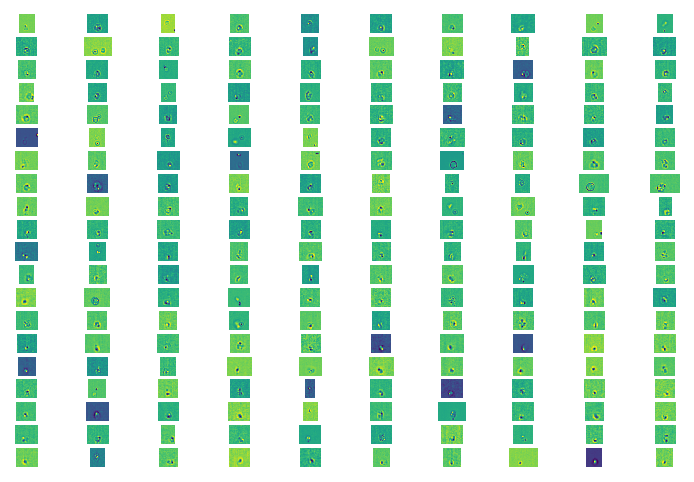

In [15]:
sel1 = df_joined["ideas_feat_h homogeneity mean_m01_bf_5"] > 17
sel2 = df_joined["scip_feat_glcm_mean_contrast_5_BF1"] < 15
core.plot_gate_zarr(sel1 & sel2, df_joined)

In [ ]:
r = df_joined[sel1 & sel2].iloc[0]
_ = plot_scip_segmentation(r)

In [ ]:
sel1 = df_joined["ideas_feat_h homogeneity mean_m01_bf_5"] < 15
sel2 = df_joined["scip_feat_glcm_mean_contrast_5_BF1"] > 20
core.plot_gate_zarr(sel1 & sel2, df_joined)

In [ ]:
r = df_joined[sel1 & sel2].iloc[0]
_ = plot_scip_segmentation(r)

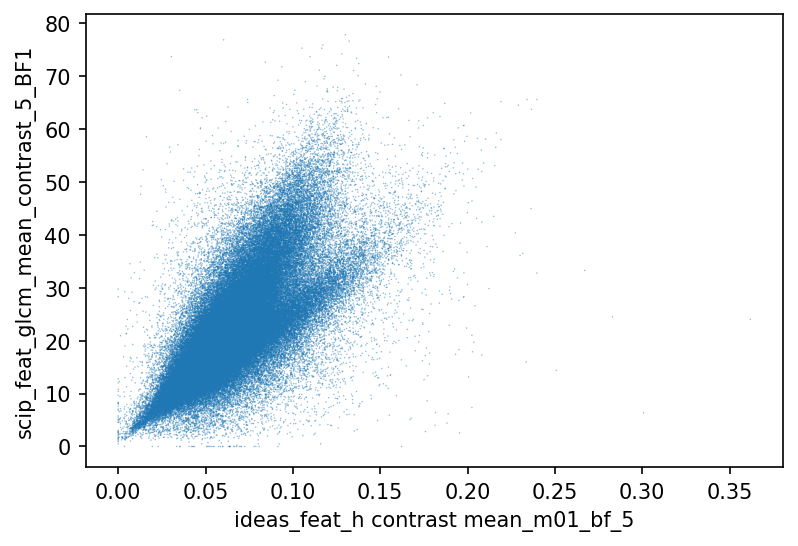

In [15]:
compare_features(df_joined, "ideas_feat_h contrast mean_m01_bf_5", "scip_feat_glcm_mean_contrast_5_BF1")

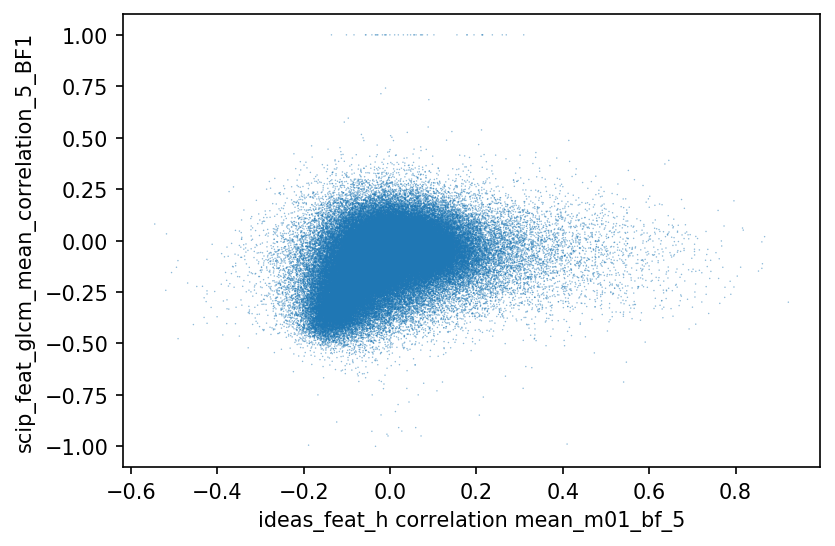

In [16]:
compare_features(df_joined, "ideas_feat_h correlation mean_m01_bf_5", "scip_feat_glcm_mean_correlation_5_BF1")

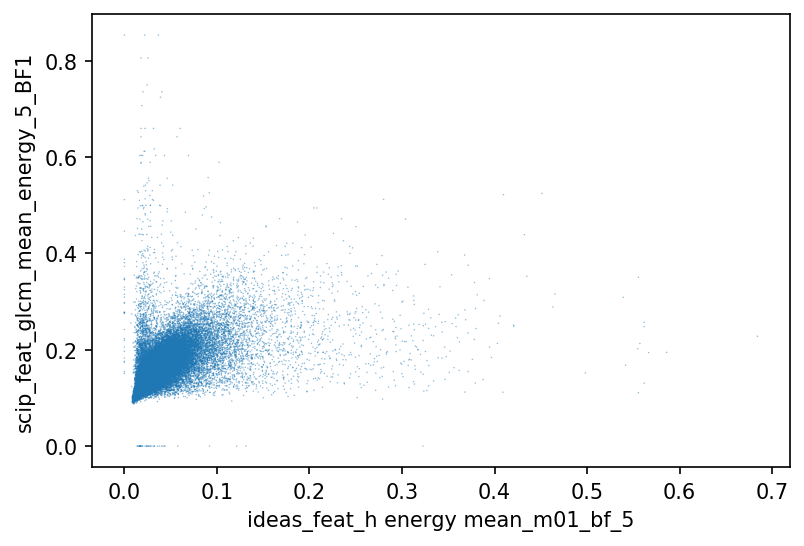

In [17]:
compare_features(df_joined, "ideas_feat_h energy mean_m01_bf_5", "scip_feat_glcm_mean_energy_5_BF1")

### Shape

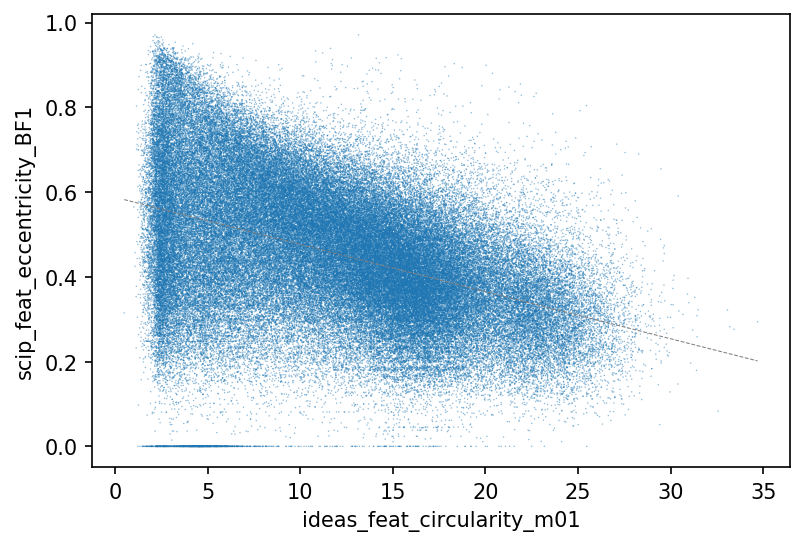

In [18]:
compare_features(df_joined, "ideas_feat_circularity_m01", "scip_feat_eccentricity_BF1")

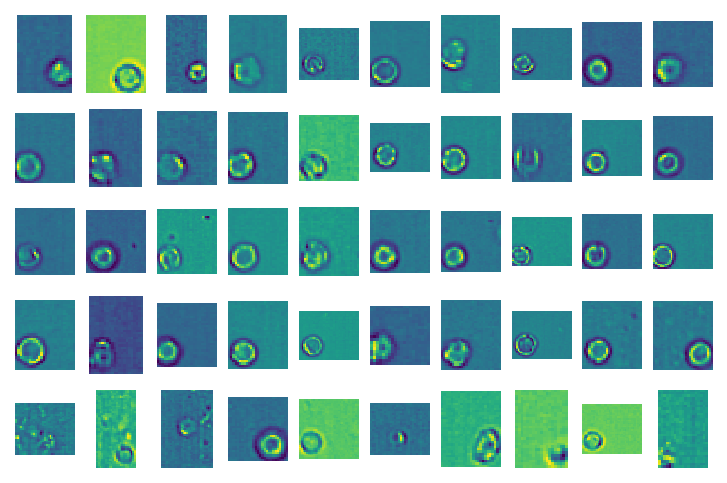

In [19]:
sel1 = df_joined["scip_feat_eccentricity_BF1"] == 0
sel2 = df_joined["ideas_feat_circularity_m01"] < 10
core.plot_gate_zarr(sel1 & sel2, df_joined, maxn=50)

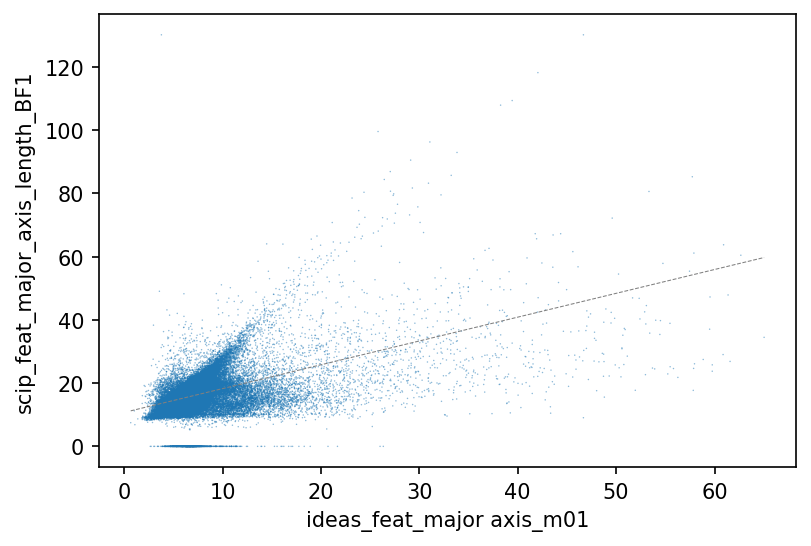

In [20]:
compare_features(df_joined, "ideas_feat_major axis_m01", "scip_feat_major_axis_length_BF1")

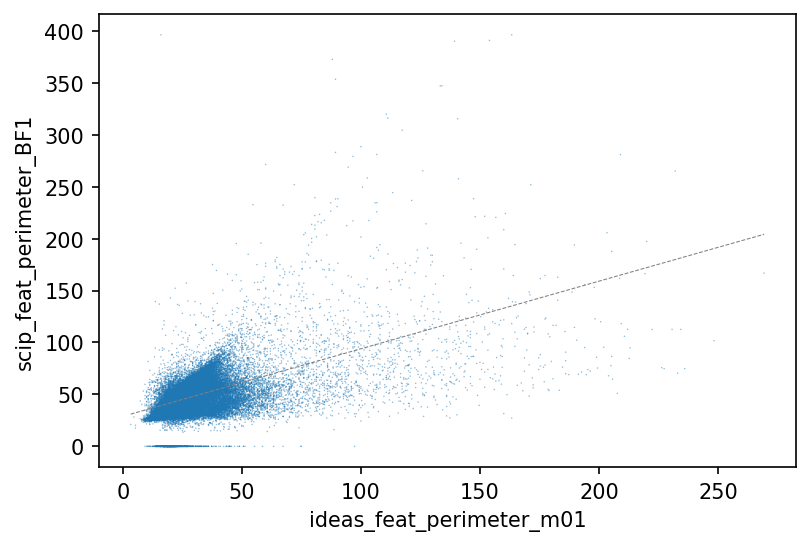

In [21]:
compare_features(df_joined, "ideas_feat_perimeter_m01", "scip_feat_perimeter_BF1")

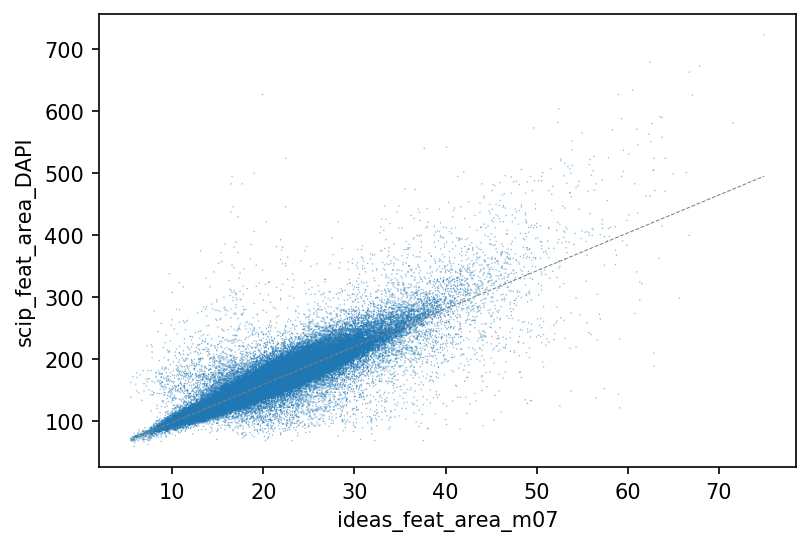

In [22]:
compare_features(df_joined, "ideas_feat_area_m07", "scip_feat_area_DAPI")

### Intensity features

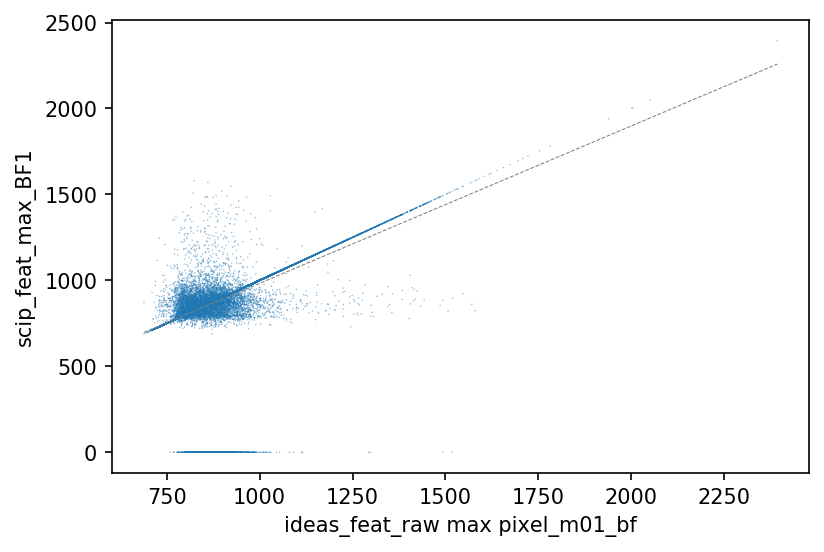

In [23]:
compare_features(df_joined, "ideas_feat_raw max pixel_m01_bf", "scip_feat_max_BF1")

In [25]:
sel1 = df_joined["scip_feat_max_BF1"] < 1000
sel2 = df_joined["scip_feat_max_BF1"] > 500
sel3 = df_joined["ideas_feat_raw max pixel_m01_bf"] > 1250

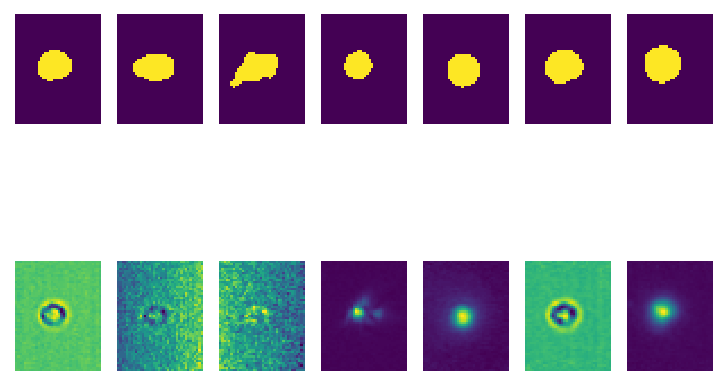

In [26]:
r = df_joined[sel1 & sel2 & sel3].iloc[1]
out = plot_scip_segmentation(r, bbox_channel_index=4)

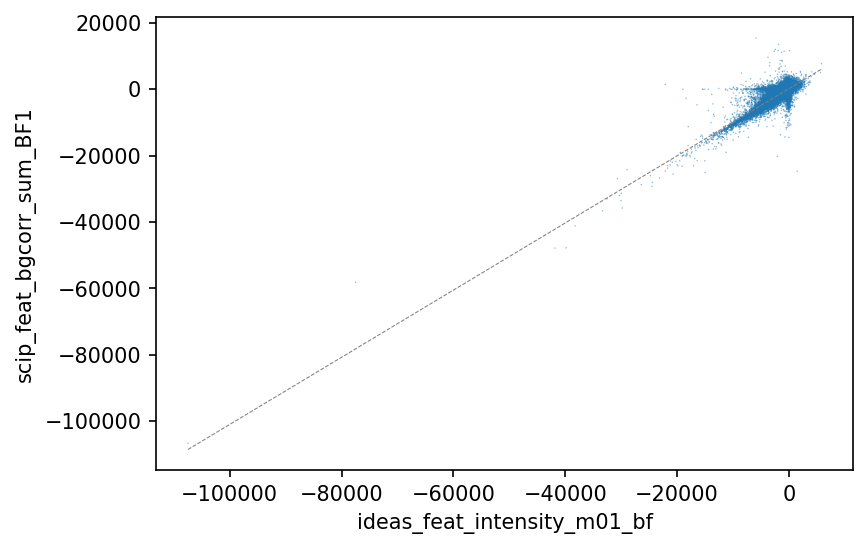

In [24]:
ax = compare_features(df_joined, "ideas_feat_intensity_m01_bf", "scip_feat_bgcorr_sum_BF1")

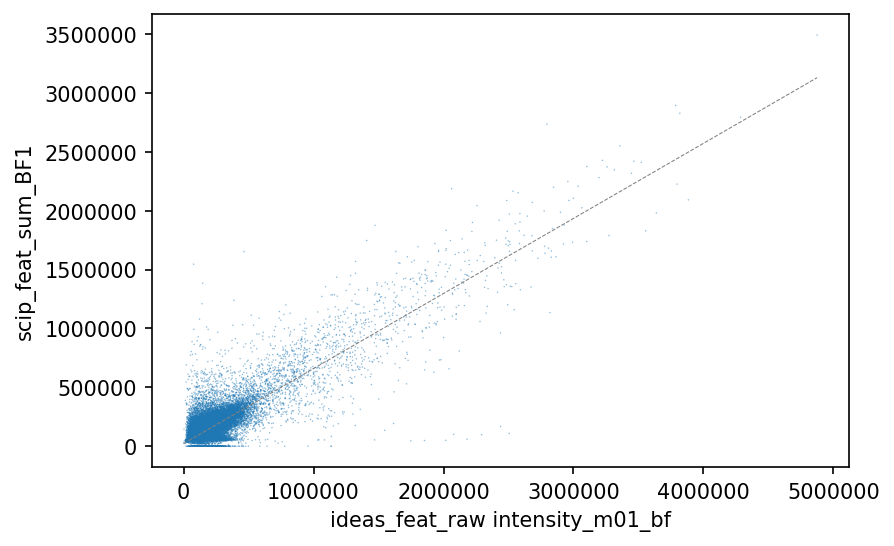

In [27]:
compare_features(df_joined, "ideas_feat_raw intensity_m01_bf", "scip_feat_sum_BF1")

/tmp/ipykernel_118435/1838533005.py:1: RankWarning: Polyfit may be poorly conditioned
  compare_features(df_joined, "ideas_feat_raw mean pixel_m01_bf", "scip_feat_mean_BF1")


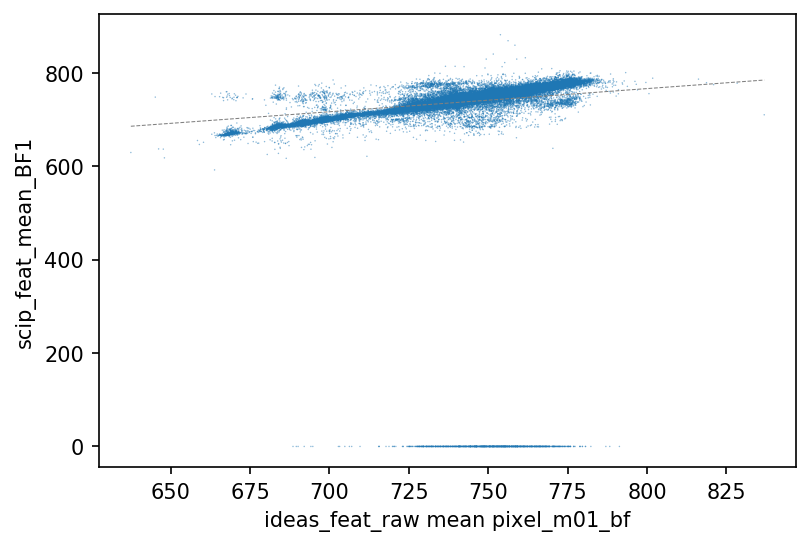

In [28]:
compare_features(df_joined, "ideas_feat_raw mean pixel_m01_bf", "scip_feat_mean_BF1")

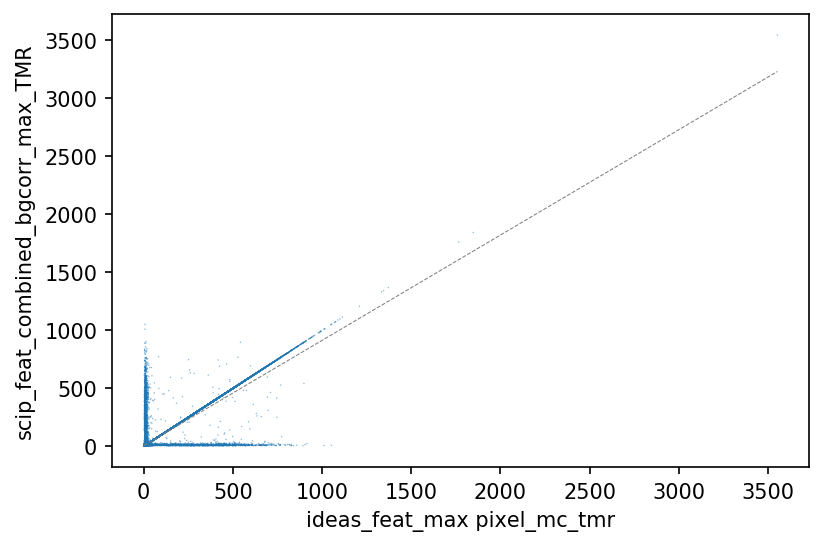

In [29]:
compare_features(df_joined, "ideas_feat_max pixel_mc_tmr", "scip_feat_combined_bgcorr_max_TMR")

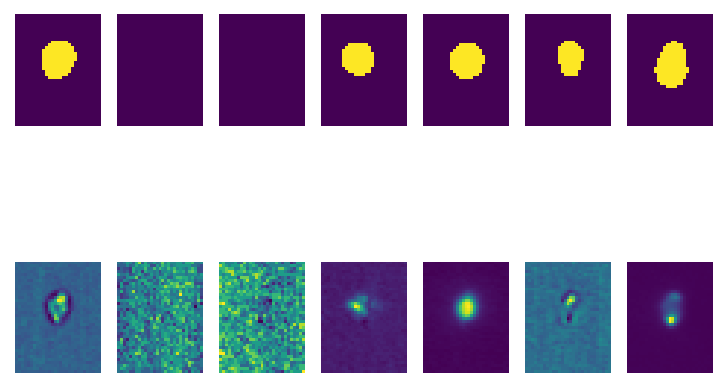

In [30]:
sel1 = df_joined["scip_feat_combined_bgcorr_max_TMR"] < 100
sel2 = df_joined["ideas_feat_max pixel_mc_tmr"] > 500
r = df_joined[sel1 & sel2].iloc[1]
out = plot_scip_segmentation(r, bbox_channel_index=4)

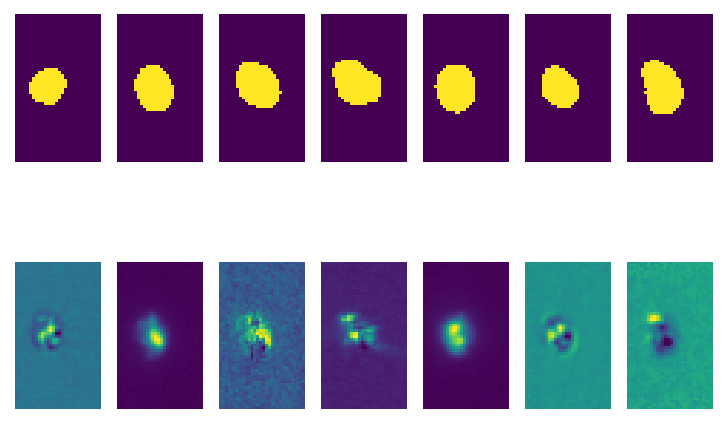

In [31]:
sel1 = df_joined["scip_feat_combined_bgcorr_max_TMR"] > 500
sel2 = df_joined["ideas_feat_max pixel_mc_tmr"] < 100
r = df_joined[sel1 & sel2].iloc[1]
out = plot_scip_segmentation(r, bbox_channel_index=4)

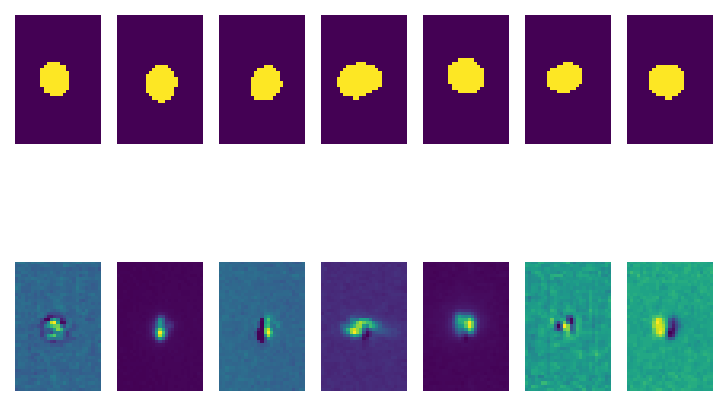

In [32]:
sel1 = df_joined["scip_feat_combined_bgcorr_max_TMR"] > 500
sel2 = df_joined["ideas_feat_max pixel_mc_tmr"] < 100
r = df_joined[sel1 & sel2].iloc[10]
out = plot_scip_segmentation(r, bbox_channel_index=4)

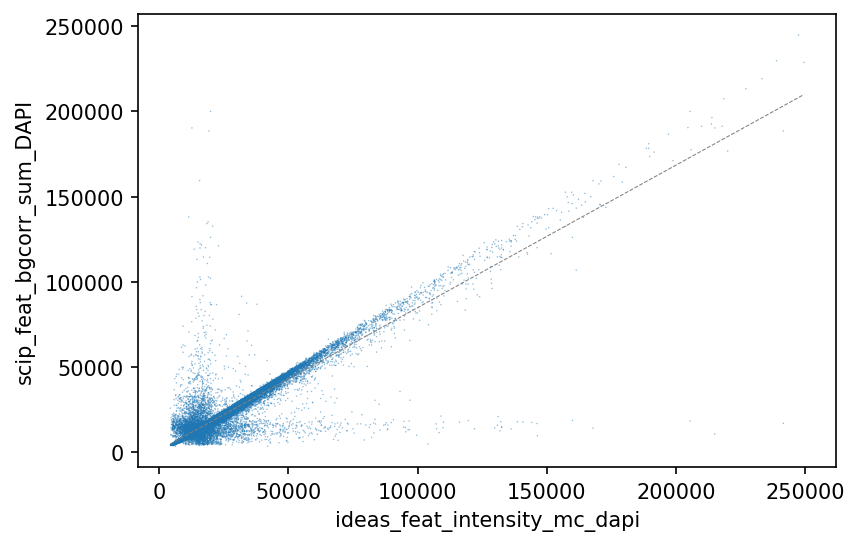

In [33]:
compare_features(df_joined, "ideas_feat_intensity_mc_dapi", "scip_feat_bgcorr_sum_DAPI")